In [2]:
import gymnasium as gym
import torch
import matplotlib.pyplot as plt
import numpy as np

# torch.cuda.is_available()
torch.backends.mps.is_available()

True

## Getting familiar with the environment

In [3]:
env = gym.make('Taxi-v3', render_mode='rgb_array', max_episode_steps=10_000)
print(f'Action space: {env.action_space}')
print(f'Observation space (states): {env.observation_space}') 
print(f"Env's horizon (maximum episode length limit): {env.spec.max_episode_steps}")

Action space: Discrete(6)
Observation space (states): Discrete(500)
Env's horizon (maximum episode length limit): 10000


## Rewards:
- -1 default per-step reward
- +20 delivering the passenger to the correct destination
- -10 executing pickup or dropoff at the wrong location

In [4]:
def plot_frame(frame):
    plt.imshow(frame)
    plt.axis('off')
    plt.show()

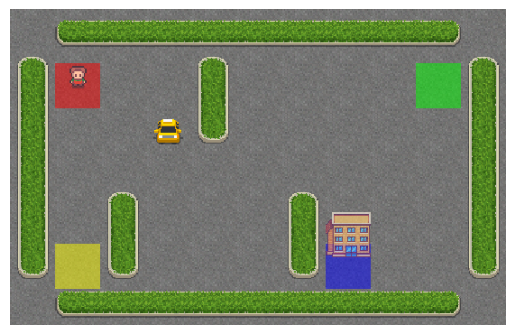

In [5]:
obs, info = env.reset()
env.unwrapped.s = 123
frame = env.render() 

plot_frame(frame)

## Create a Baseline Model 

This is a good practice for any ML project

In this case we are creating a random agent as our RL baseline model§

In [6]:
class RandomAgent:
    """ 
    The agent selects actions randomly
    """
    def __init__(self, env):
        self.env = env

    def get_action(self, state) -> int:
        """
        We have a `statea` param to keep an standard between our RL agents
        However in this case we don't use it, as we're just sampling randomly from 
        our state space
        """
        return int(self.env.action_space.sample())


agent = RandomAgent(env)
agent.get_action(state=123)

1

In [7]:
env.unwrapped.P[123][4]

[(1.0, 123, -10, False)]

## Initial Training loop

In [8]:
from tqdm import tqdm

n_episodes = 100

frames = [] # for plotting later
timesteps_per_episode = []
penalties_per_episode = []

for i in tqdm(range(0, n_episodes)):
    state, info = env.reset()
    epochs, penalties, reward = 0, 0, 0
    done = False

    while not done:
        action = agent.get_action(state)
        state, reward, terminated, truncated, info  = env.step(action)

        if reward == -10:
            penalties += 1

        # frames.append({
        #     'frame': env.render(),
        #     'state': state,
        #     'action': action,
        #     'reward': reward
        # })

        epochs += 1
        done = terminated or truncated
    
    timesteps_per_episode.append(epochs)
    penalties_per_episode.append(penalties)

100%|██████████| 100/100 [00:02<00:00, 40.19it/s]


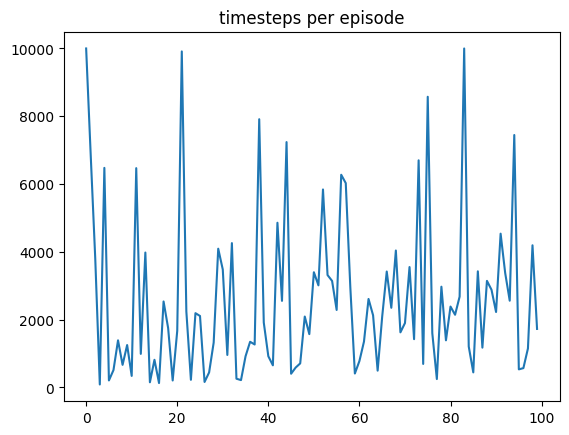

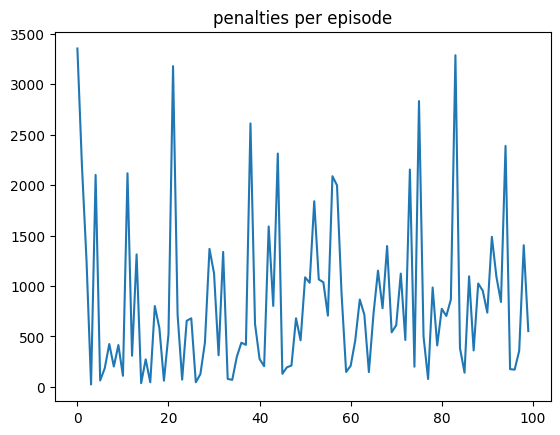

In [11]:
plt.plot(timesteps_per_episode)
plt.title('timesteps per episode')
plt.show()

plt.plot(penalties_per_episode)
plt.title('penalties per episode')
plt.show()

## Animate the frames

In [36]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        plot_frame(frame['frame'])
        print(f'Timestep: {i+1}')
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(0.01)

# print_frames(frames)

## Now the good stuff
## The Q-Learning Agent

In [ ]:
class QLearningAgent:
    def __init__(self, env, alpha, gamma):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma

        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))

    def get_action(self, state):
        return np.argmax(self.q_table[state])
    
    def update_parameters(self, state, action , reward, next_state):
        # Q-learning update rule/formula
        old_value = self.q_table[state][action]
        new_max = np.max(self.q_table[next_state])
        new_value = old_value + self.alpha * (reward + self.gamma * new_max - old_value)

        self.q_table[state][action] = new_value

In [ ]:
import random

n_episodes = 10_000
timesteps_per_episode = []
penalties_per_episode = []
epsilon = 0.1
alpha = 0.1
gamma = 0.6

agent = QLearningAgent(env, alpha, gamma)

for i in tqdm(range(0, n_episodes)):
    state, info = env.reset()
    epochs, penalties, reward = 0, 0, 0
    done = False

    while not done:
        if random.uniform(0,1) <= epsilon:
            # Explore
            action = int(env.action_space.sample())
        else:
            # Exploit
            action = agent.get_action(state)

        next_state, reward, terminated, truncated, info  = env.step(action)

        agent.update_parameters(state, action, reward, next_state)

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        done = terminated or truncated
    
    timesteps_per_episode.append(epochs)
    penalties_per_episode.append(penalties)

100%|██████████| 10000/10000 [00:03<00:00, 2953.39it/s]


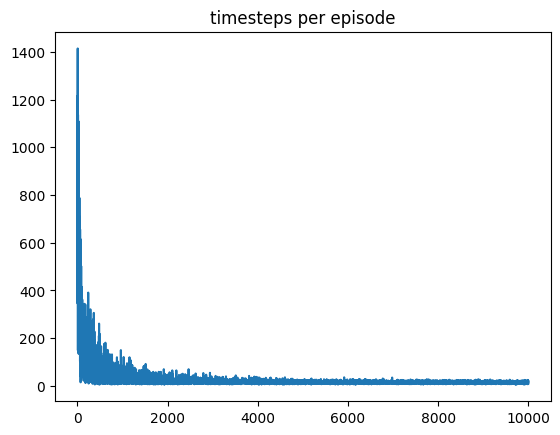

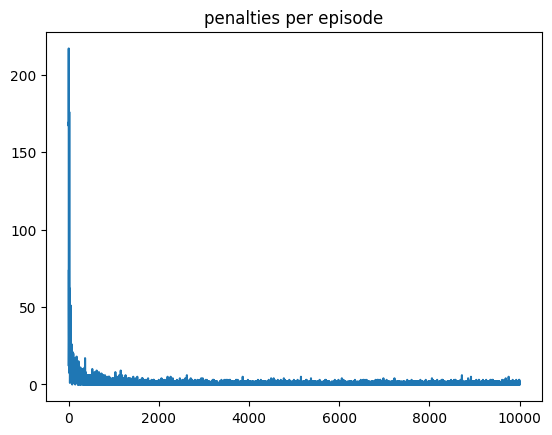

In [39]:
plt.plot(timesteps_per_episode)
plt.title('timesteps per episode')
plt.show()

plt.plot(penalties_per_episode)
plt.title('penalties per episode')
plt.show()

In [ ]:
# TODO: Hyperparameter tuning
# try different values for alpha and gamma
# alpha = []
# gamma = []